# Analysis of the Ground State of a NSM Hamiltonian

We want to understand if the Quasiparticle decomposition [CITE HERE PAPERS] of the NSM Hamiltonian can be easily implemented. In order to do that, we want to look at the component of a ground state of a Nucleus using the NSM representation. In this case, since the configuration space is small, we are going to study a p-shell Nucleus.

#### Imports

In [1]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

file_name='data/cki'
SPS=SingleParticleState(file_name=file_name)

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Hyperparameters

In [2]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

#### Set up of the Quantum Objects and computation of the ground state

In [3]:

# Compute the J^2 matrix and the M matrix
matrix_j,energies=get_twobody_nuclearshell_model(file_name='data/j2.int')
mij_matrix=np.zeros((energies.shape[0],energies.shape[0]))
diag_j=np.zeros(energies.shape[0])
diag_m=np.zeros(energies.shape[0])
label=[]
for i in range(energies.shape[0]):
    n,l,j,m,t,tz=SPS.state_encoding[i]
    diag_j[i]=j*(j+1)
    diag_m[i]=m
    label.append((j,m,tz))
    for r in range(energies.shape[0]):
        n,l,j,mr,t,tz=SPS.state_encoding[r]
        mij_matrix[i,r]=m-mr


Joperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
    symmetries=[SPS.total_M_zero]
)

Joperator.get_twobody_interaction(twobody_dict=matrix_j)
Joperator.get_external_potential(diag_j)
Joperator.get_hamiltonian()


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
    symmetries=[SPS.total_M_zero]
)

Moperator.get_external_potential(diag_m)
Moperator.get_hamiltonian()

# compute the NSM Hamiltonian
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))










j2=psi0.transpose().dot(Joperator.hamiltonian.dot(psi0))
jvalue=0.5 * ( np.sqrt(4.0 * j2 + 1) - 1 )

print('total_J=',jvalue)
print('m value=',Moperator.hamiltonian @ NSMHamiltonian.hamiltonian- NSMHamiltonian.hamiltonian @ Moperator.hamiltonian)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.82it/s]
592it [00:00, 843.54it/s]


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.81it/s]


size= 12 6


1424it [00:01, 818.96it/s]


[-30.29539461]
total_m= [0.]
total_J= [[5.88418203e-15]]
m value= 


#### Analysis of the component of the Ground state

(51,)
(51, 1)
[[-18.84503267]]
(51, 1)
[[-16.51006886]]


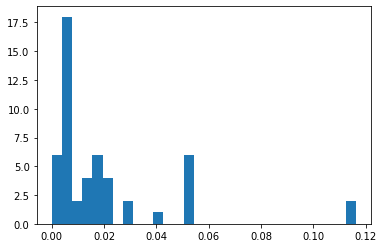

0.546263130260983


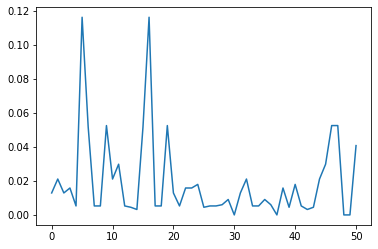

0.11630150268642288


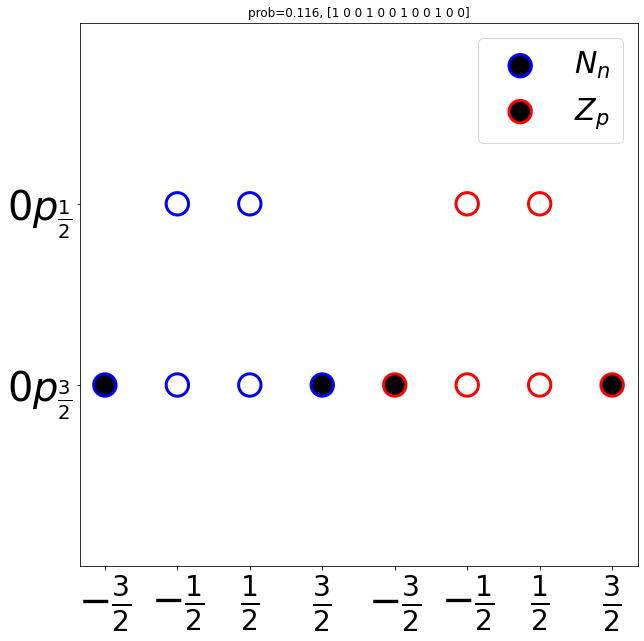

0.1163015026864225


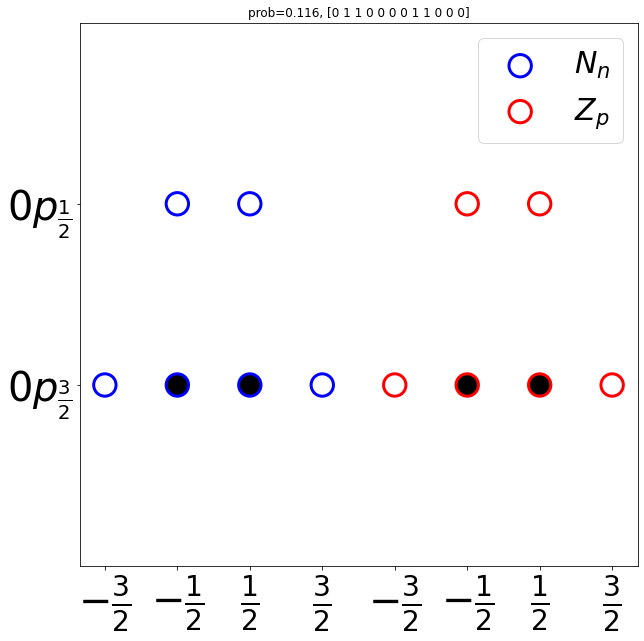

0.05257025284727388


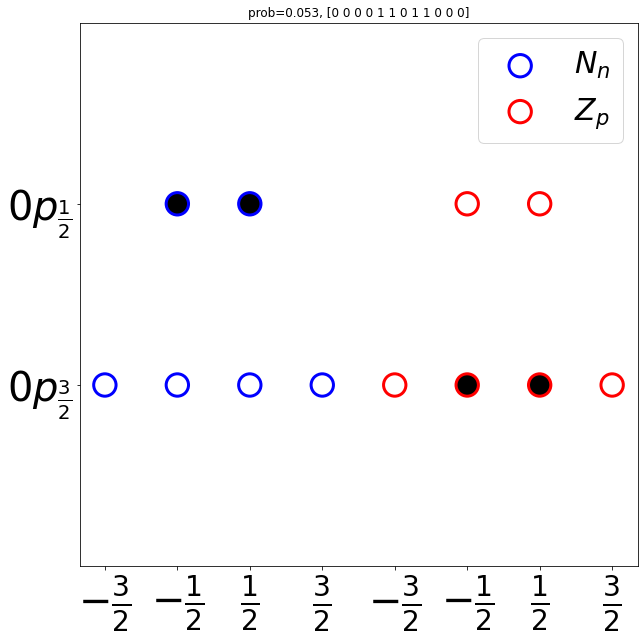

0.05257025284727385


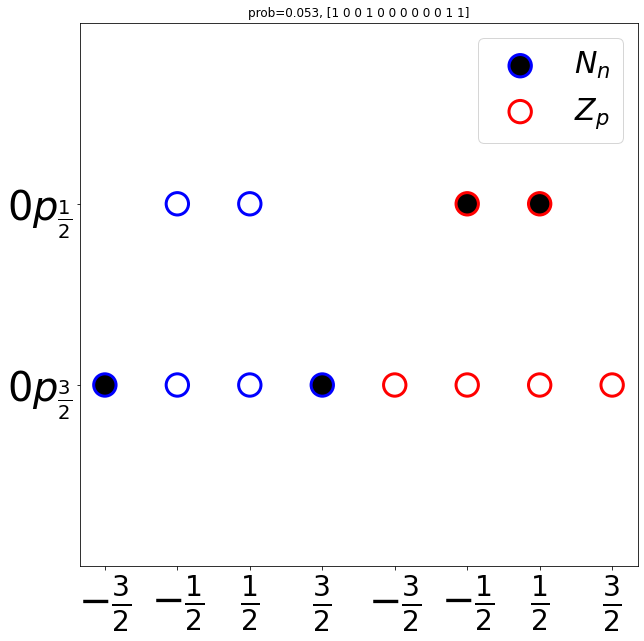

0.05257025284727384


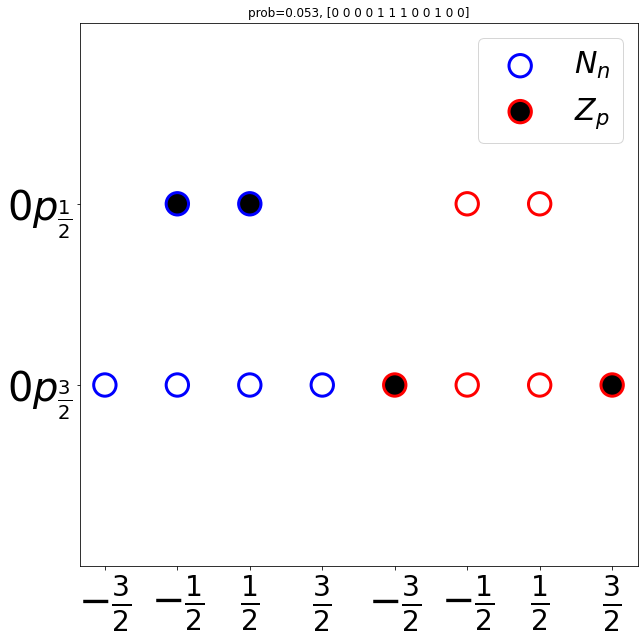

0.05257025284727382


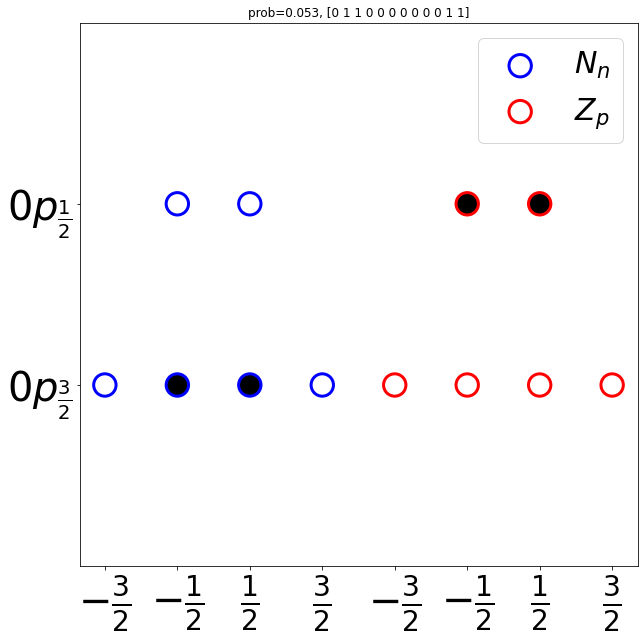

0.0516895567495212


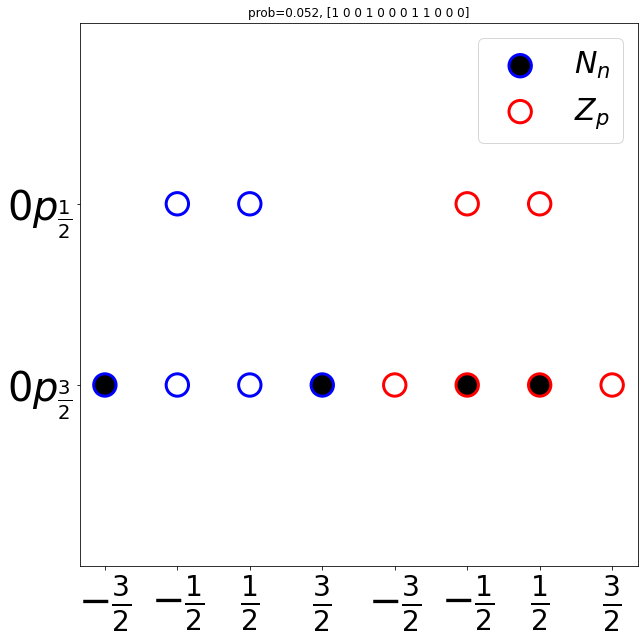

0.051689556749521075


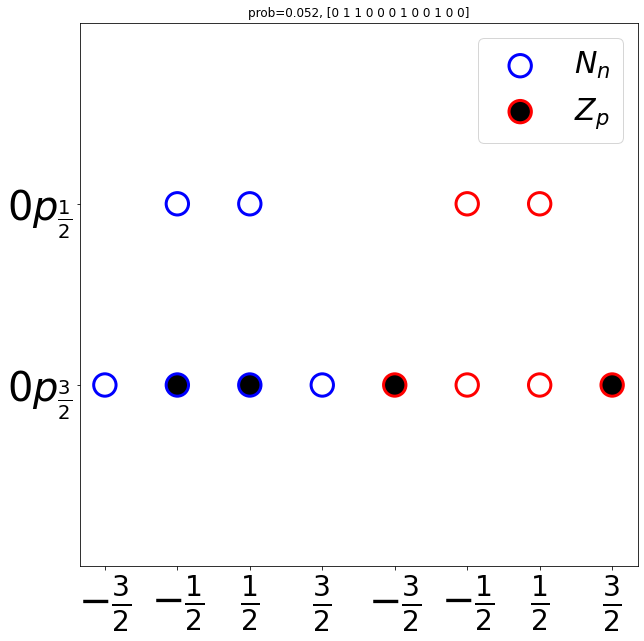

0.040775502847359334


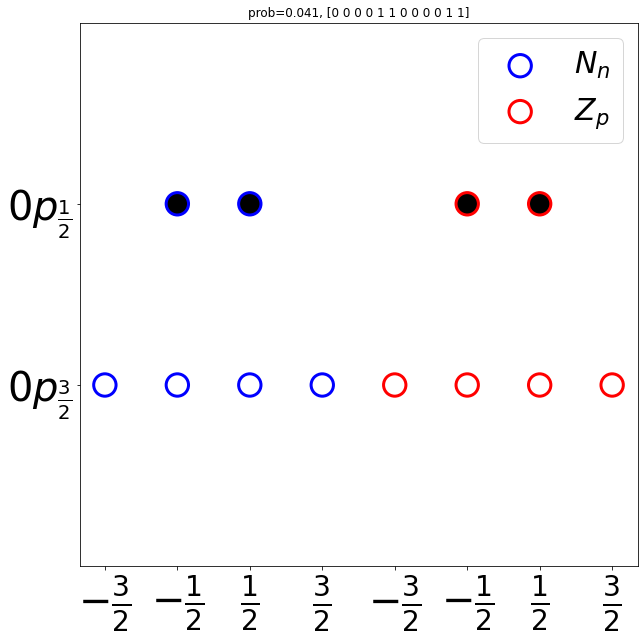

0.029836278175200463


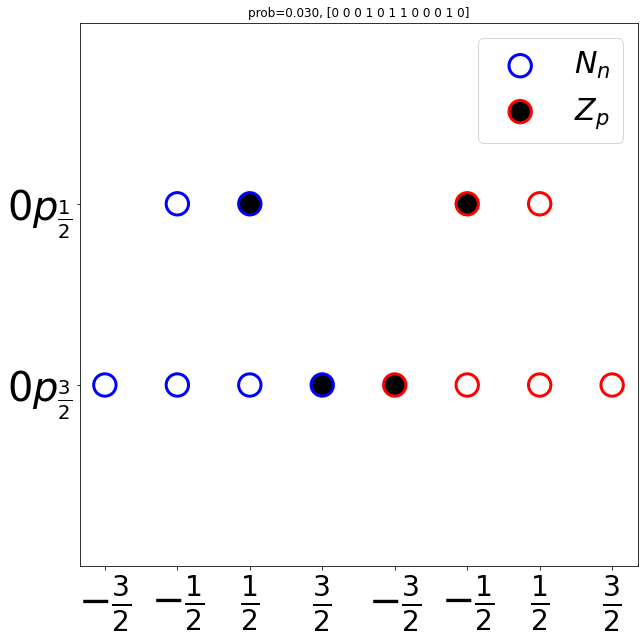

0.029836278175200435


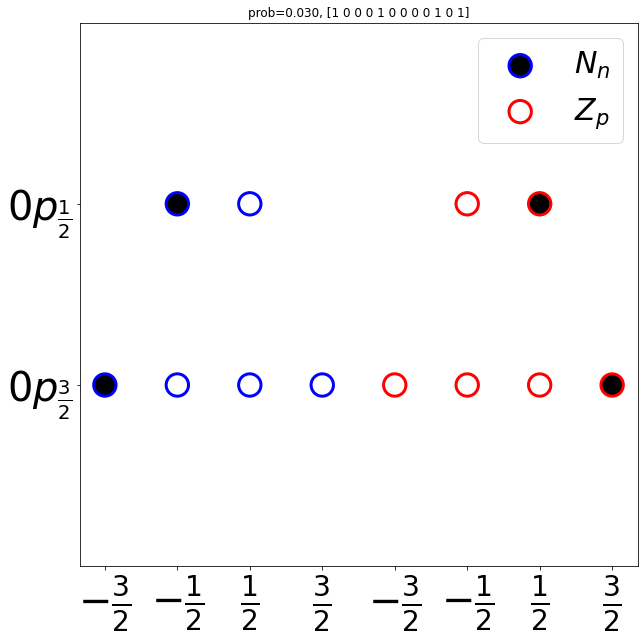

0.021113743766949612


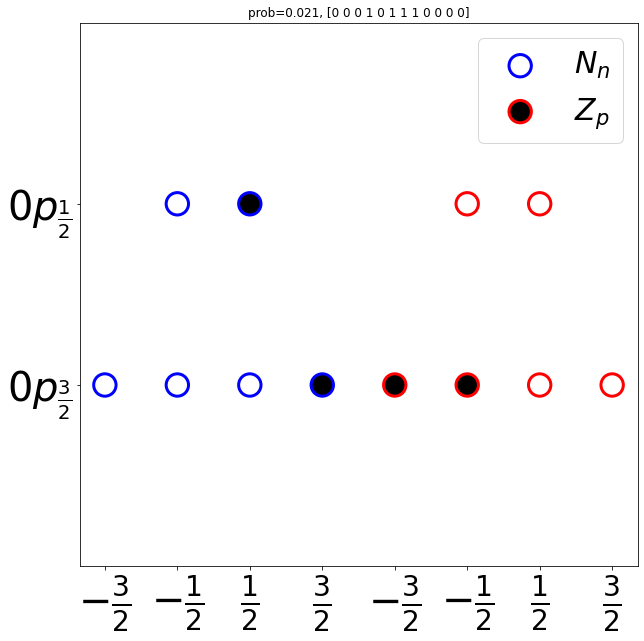

0.021113743766949602


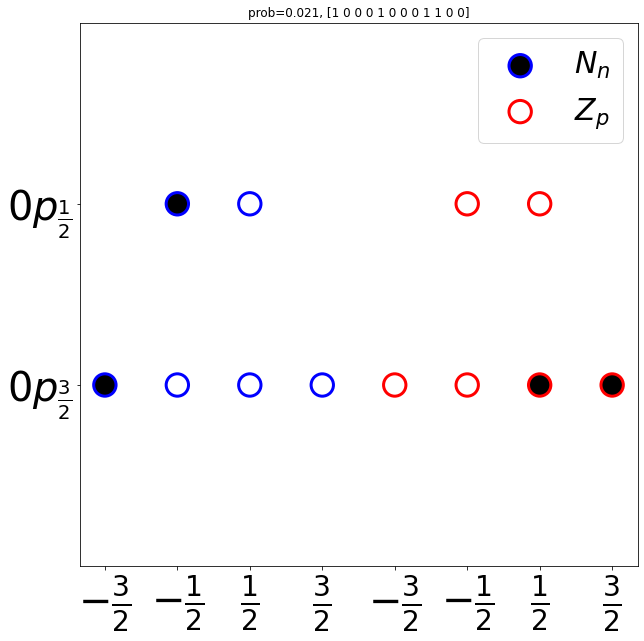

0.021113743766949595


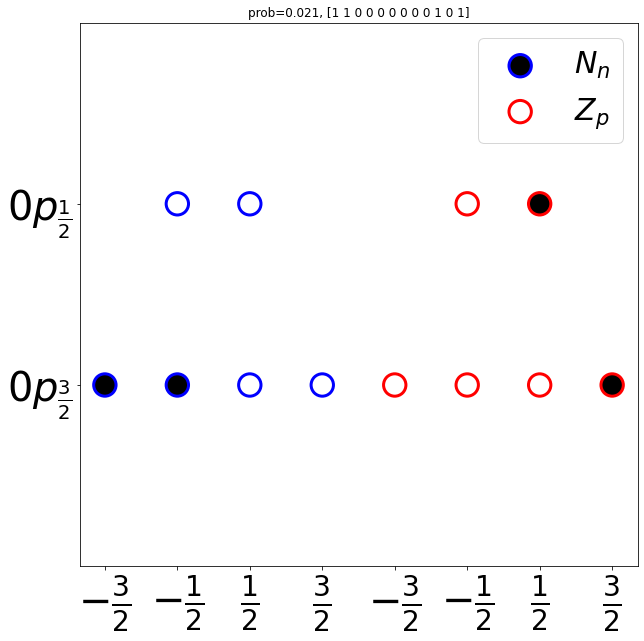

0.021113743766949578


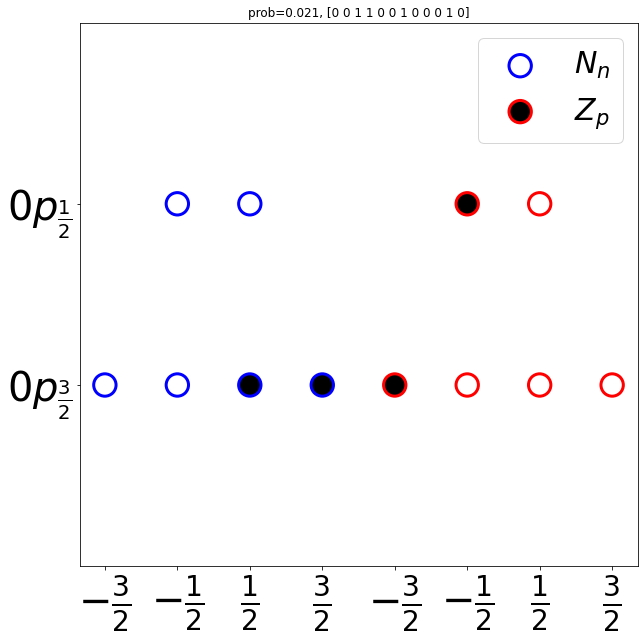

0.01795723708664423


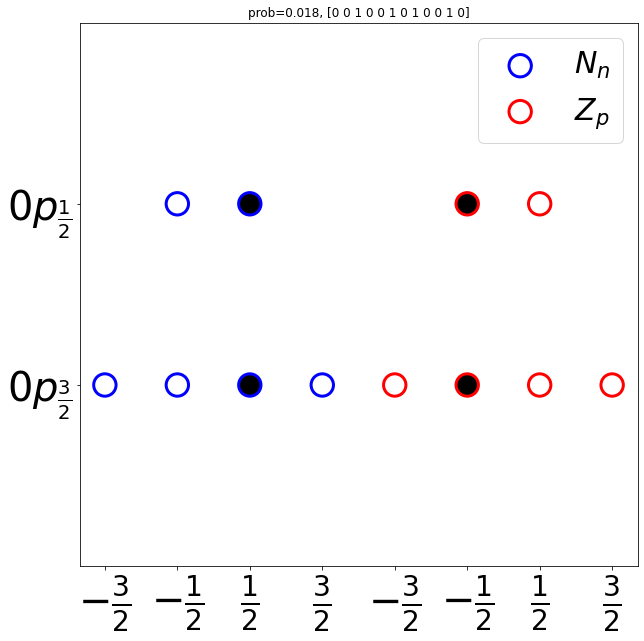

0.01795723708664422


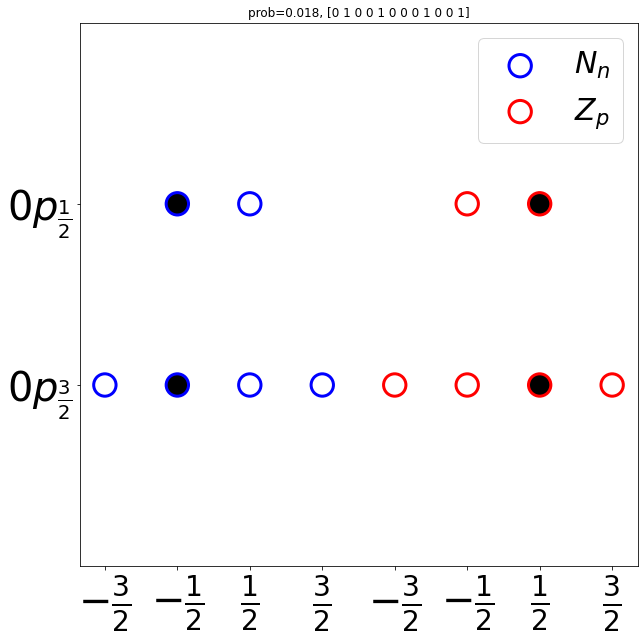

0.015835307825212162


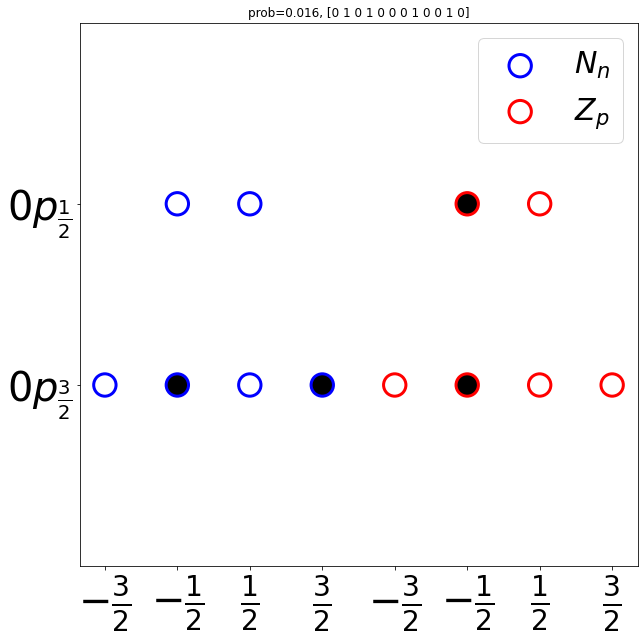

0.015835307825212155


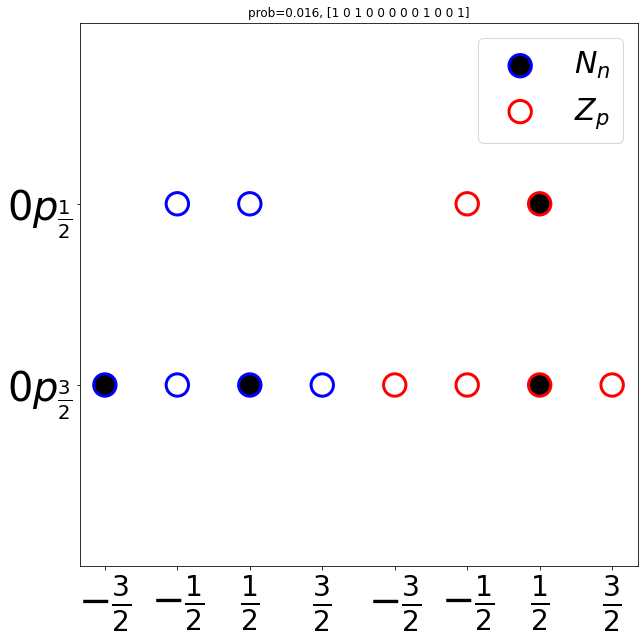

0.01583530782521215


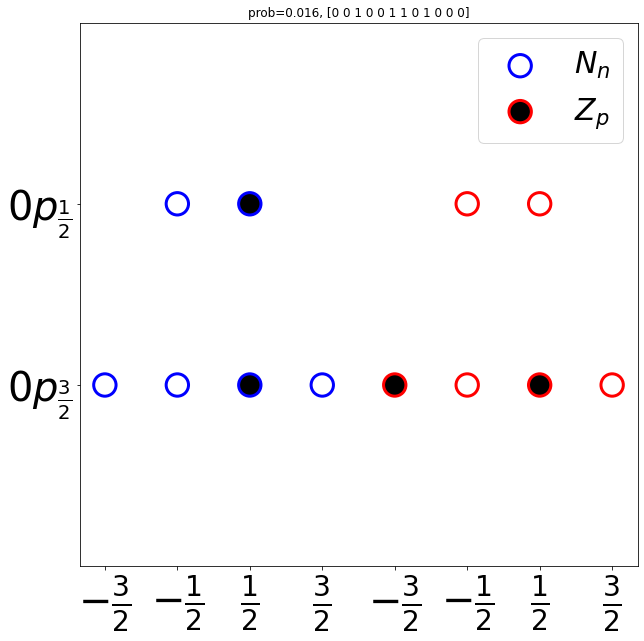

0.01583530782521215


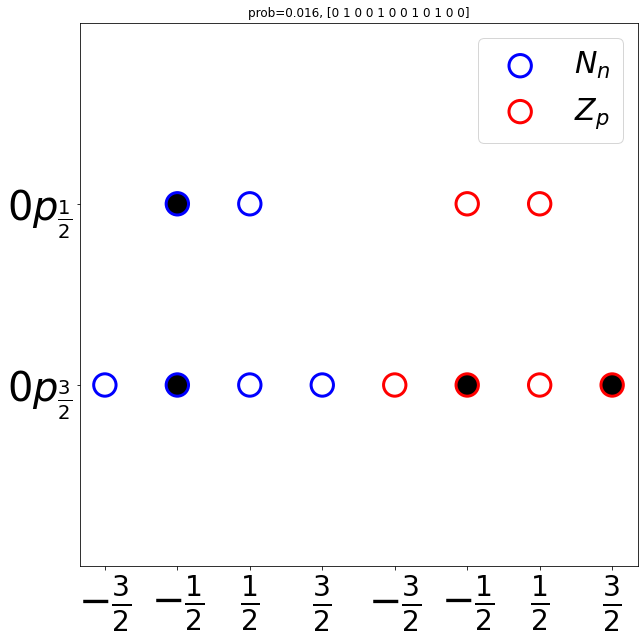

0.012922389187380322


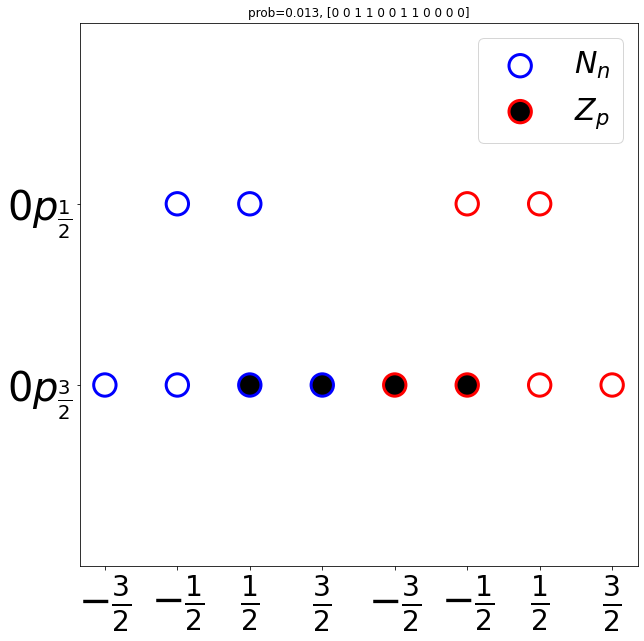

0.012922389187380303


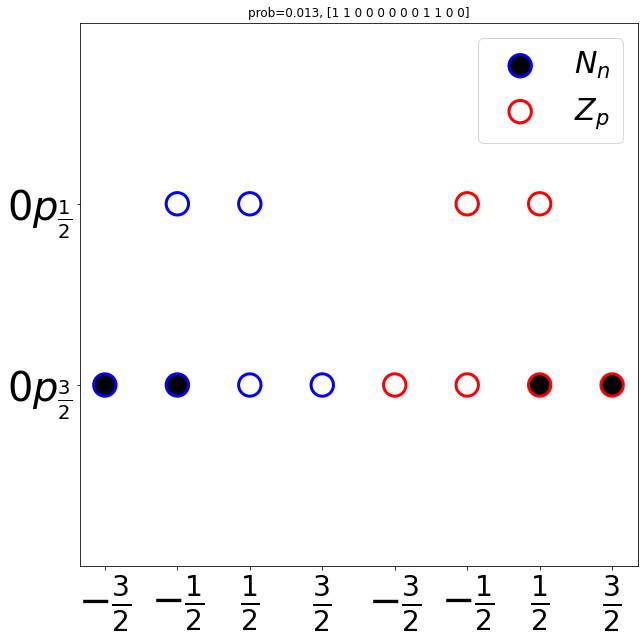

0.012922389187380262


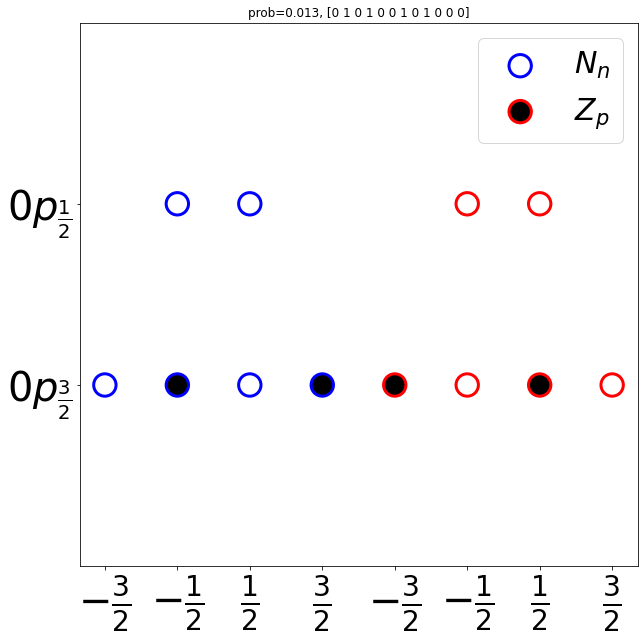

0.012922389187380246


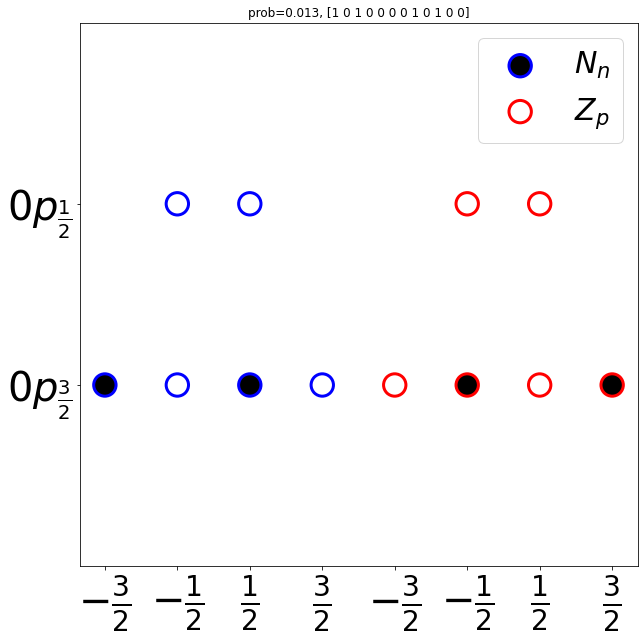

In [31]:
# coordinates of the basis points
x_coordinates=[ i for i in range(4)]+[i for i in range(1,3)]+[i for i in range(4,8)]+[i for i in range(5,7)]
y_coordinates=np.zeros(len(x_coordinates))
y_coordinates[4:6]=y_coordinates[10:12]=1




# we need to get the argsort for
prob=(np.conj(psi0)*psi0)[:,0]
print(prob.shape)
idx_sort=np.argsort(-1*prob[:])

cutoff_value=0.05
cutoff_prob=prob[prob>cutoff_value]


psi_cutoff=psi0.copy()
psi_cutoff[prob<cutoff_value]=0.
psi_cutoff=psi_cutoff/np.linalg.norm(psi_cutoff)
print(psi_cutoff.shape)
print(psi_cutoff.conj().T @ NSMHamiltonian.hamiltonian @ psi_cutoff)

psi_out=psi0.copy()
psi_out[prob>=cutoff_value]=0.
psi_out=psi_out/np.linalg.norm(psi_out)
print(psi_out.shape)
print(psi_out.conj().T @ NSMHamiltonian.hamiltonian @ psi_out)



plt.hist(prob,bins=30)
plt.show()

print(np.sum(cutoff_prob))
plt.show()

plt.plot(prob)
plt.show()


for i in idx_sort:
    
    if prob[i]>0.01:
        plt.figure(figsize=(10,10))
        plt.scatter(x_coordinates,y_coordinates,)
        print(prob[i])
        plt.title(f'prob={prob[i]:.3f}, {NSMHamiltonian.basis[i]}')
        plt.scatter(
            x_coordinates[:6],
            y_coordinates[:6],
            c=NSMHamiltonian.basis[i,:6],  # Colors determined by the array
            cmap='Greys',  # Colormap for coloring
            edgecolors='blue',  # Neutrons
            linewidth=3,  # Width of the edges
            s=500,  # Size of the points
            facecolor='none',  # No fill
            label=r'$N_n$'
        )
        plt.scatter(
            x_coordinates[6:],
            y_coordinates[6:],
            c=NSMHamiltonian.basis[i,6:],  # Colors determined by the array
            cmap='Greys',  # Colormap for coloring
            edgecolors='red',  # Protons
            linewidth=3,  # Width of the edges
            s=500,  # Size of the points
            facecolor='none',  # No fill
            label=r'$Z_p$'
        )
        plt.legend(fontsize=30)
        plt.yticks([0,1],[r'$0p_{\frac{3}{2}}$',r'$0p_{\frac{1}{2}}$'])
        plt.xticks([i for i in range(4)]+[i for i in range(4,8)],2*[r'$- \frac{3}{2}$',r'$- \frac{1}{2}$',r'$ \frac{1}{2}$',r'$\frac{3}{2}$'])
        plt.tick_params(which='major',labelsize=40)
        plt.ylim([-1,2])
        plt.show()
         